# 誤差逆伝播と自動微分


# 自動微分

まずは触ってみましょう！

In [1]:
import torch

1次関数の微分

In [2]:
x = torch.tensor([1.], requires_grad=True)

y = x*2
print(torch.autograd.grad(y, x))  # dy/dx|x=1 = 2 (1次関数なのでxの値に関係ない)

x = torch.tensor([3.], requires_grad=True)

y = x*2
print(torch.autograd.grad(y, x))  # dy/dx|x=3 = ?? (1次関数なのでxの値に関係ない)

(tensor([2.]),)
(tensor([2.]),)


高次関数の微分
- 深層学習で二乗はたまに出現します(誤差関数など)

In [3]:
x = torch.tensor([3.], requires_grad=True)

y = x**2
print(torch.autograd.grad(y, x))  # dy/dx|x=3 = ??

y = x**3
print(torch.autograd.grad(y, x))  # dy/dx|x=3 = ??

(tensor([6.]),)
(tensor([27.]),)


In [4]:
x = torch.tensor([3.], requires_grad=True)

y = x**2 + x*2 + 2
print(torch.autograd.grad(y, x))  # dy/dx|x=3 = ??

# メモリ使用量を抑えるため一度微分されるとyと他の変数の関係は捨てられることに注意
# print(torch.autograd.grad(y, x))

(tensor([8.]),)


二階微分
- 深層学習では普通は使わないですが使うときもあります
  - [\[DL輪読会\] DeepLearningと曲がったパラメータ空間](https://www.slideshare.net/DeepLearningJP2016/dldeeplearning-scalable-trustregion-method-for-deep-reinforcement-learning-using-kroneckerfactored-approximation)
  - [\[DL輪読会\]1次近似系MAMLとその理論的背景](https://www.slideshare.net/DeepLearningJP2016/dl1maml)

In [5]:
# create_graphをTrueにしないと他の変数との関係が保存されず微分できないので注意
x = torch.tensor([2.], requires_grad=True)

y = x**3 + x**2 + x + 1

dy = torch.autograd.grad(y, x, create_graph=True)  # 3x**2 + 2x + 1 | x=2
print(dy)

ddy = torch.autograd.grad(dy[0], x, create_graph=True)  # ??
print(ddy)

dddy = torch.autograd.grad(ddy[0], x)  # ??
print(dddy)

(tensor([17.], grad_fn=<AddBackward0>),)
(tensor([14.], grad_fn=<AddBackward0>),)
(tensor([6.]),)


適当な関数も微分してみましょう

- いろんな関数が実装されています: https://pytorch.org/docs/stable/torch.html#math-operations

In [6]:
print("exp")
x = torch.tensor([1.], requires_grad=True)
y = torch.exp(x)                                        # e^x
dy = torch.autograd.grad(y, x, create_graph=True)       # e^x
ddy = torch.autograd.grad(dy[0], x, create_graph=True)  # e^x
dddy = torch.autograd.grad(ddy[0], x)                   # e^x
print(y); print(dy); print(ddy); print(dddy)

print("\nsin")
x = torch.tensor([3.141], requires_grad=True)
y = torch.sin(x)                                        # sin(x)
dy = torch.autograd.grad(y, x, create_graph=True)       # cos(x)
ddy = torch.autograd.grad(dy[0], x, create_graph=True)  # -sin(x)
dddy = torch.autograd.grad(ddy[0], x)                   # -cos(x)
print(y); print(dy); print(ddy); print(dddy)

exp
tensor([2.7183], grad_fn=<ExpBackward>)
(tensor([2.7183], grad_fn=<MulBackward0>),)
(tensor([2.7183], grad_fn=<MulBackward0>),)
(tensor([2.7183]),)

sin
tensor([0.0006], grad_fn=<SinBackward>)
(tensor([-1.0000], grad_fn=<MulBackward0>),)
(tensor([-0.0006], grad_fn=<MulBackward0>),)
(tensor([1.0000]),)


# 逆伝播

- 逆伝播によって、出力yを大きくするために重みを動かすべき方向が分かります。
- 具体的には合成関数の微分 (**連鎖律**) が使われています。

In [7]:
x = torch.tensor([3.], requires_grad=True)

w1 = torch.tensor([2.], requires_grad=True)
b1 = torch.tensor([-10.], requires_grad=True)

w2 = torch.tensor([4.], requires_grad=True)
b2 = torch.tensor([7.], requires_grad=True)

h1 = w1*x+b1  # -4
y = w2*h1+b2  # -9

print(y)

tensor([-9.], grad_fn=<AddBackward0>)


In [8]:
# yを大きくするには...？ (大きく==正の方向に動かす)
print(torch.autograd.grad(y, w1, retain_graph=True))  # 増やせ
print(torch.autograd.grad(y, b1, retain_graph=True))  # 増やせ
print(torch.autograd.grad(y, w2, retain_graph=True))  # ??
print(torch.autograd.grad(y, b2, retain_graph=True))  # ??

(tensor([12.]),)
(tensor([4.]),)
(tensor([-4.]),)
(tensor([1.]),)


In [9]:
# 一発で全部のパラメータに関して微分してくれます。便利！
y.backward(retain_graph=True)

# backwardを使うと、各パラメータに勾配情報.gradがセットされる
# backwardを二回以上実行するとgradが加算されます
print(w1.grad); print(b1.grad); print(w2.grad); print(b2.grad)

tensor([12.])
tensor([4.])
tensor([-4.])
tensor([1.])


# 誤差逆伝播

- lossに対して連鎖律を適用するとlossを小さくするような変数の動かし方がわかります。(**誤差逆伝播**)

In [10]:
import numpy as np

x = torch.tensor([3.])
true = torch.tensor([10.])

w = torch.tensor([5.], requires_grad=True)
b = torch.tensor([1.], requires_grad=True)

print(w); print(b)

pred = w*x+b
loss = torch.pow(pred - true, 2)

print("pred = {}, true = {}, loss = {}".format(pred.item(), true.item(), loss.item()))

loss.backward()
print(w.grad); print(b.grad)

tensor([5.], requires_grad=True)
tensor([1.], requires_grad=True)
pred = 16.0, true = 10.0, loss = 36.0
tensor([36.])
tensor([12.])


- lossを減らす方向が分かったので、wとbを更新してみましょう。
- 勾配が正なら負の方向に、勾配が負なら正の方向に、勾配×**学習率**の値だけ動かします。(これを**勾配降下**といいます。)

In [11]:
lr = 0.01  # learning_rate, 学習率

w = torch.tensor([w.detach() - lr * w.grad], requires_grad=True)
b = torch.tensor([b.detach() - lr * b.grad], requires_grad=True)

print(w); print(b)

pred = w*x+b
loss = torch.pow(pred - true, 2)

print("pred = {}, true = {}, loss = {}".format(pred.item(), true.item(), loss.item()))

tensor([4.6400], requires_grad=True)
tensor([0.8800], requires_grad=True)
pred = 14.800000190734863, true = 10.0, loss = 23.040000915527344


- さらに更新してみましょう。誤差が小さくなっていることが確認できると思います。
  - うまく行かない場合は学習率が大きすぎる可能性が高いです。

In [12]:
loss.backward()

w = torch.tensor([w.detach() - lr * w.grad], requires_grad=True)
b = torch.tensor([b.detach() - lr * b.grad], requires_grad=True)

pred = w*x+b
loss = torch.pow(pred - true, 2)

print("pred = {}, true = {}, loss = {}".format(pred.item(), true.item(), loss.item()))

pred = 13.84000015258789, true = 10.0, loss = 14.745600700378418


<img src="https://tutorials.chainer.org/ja/_images/13_13.png" width="800">

出典: https://tutorials.chainer.org/ja/13_Basics_of_Neural_Networks.html

# 最適化

- 変数を自動で更新する実装も備わっています。

In [13]:
import numpy as np
from torch import optim

x = torch.tensor([3.])
true = torch.tensor([10.])

w = torch.tensor([5.], requires_grad=True)
b = torch.tensor([1.], requires_grad=True)

print(w); print(b)
optimizer = optim.SGD((w, b), lr=0.01, momentum=0)

pred = w*x+b 
loss = torch.pow(pred - true, 2)

print("pred = {}, true = {}, loss = {}".format(pred.item(), true.item(), loss.item()))

optimizer.zero_grad()
loss.backward()
optimizer.step()

print("-"*60)
print(w); print(b)

pred = w*x+b
loss = torch.pow(pred - true, 2)
print("pred = {}, true = {}, loss = {}".format(pred.item(), true.item(), loss.item()))

tensor([5.], requires_grad=True)
tensor([1.], requires_grad=True)
pred = 16.0, true = 10.0, loss = 36.0
------------------------------------------------------------
tensor([4.6400], requires_grad=True)
tensor([0.8800], requires_grad=True)
pred = 14.800000190734863, true = 10.0, loss = 23.040000915527344


In [14]:
del w, b

- 変数をまとめてクラスに、最適化を関数にして複数回変数を更新しましょう

In [15]:
class Model(object):
  def __init__(self):
    self.w = torch.tensor([5.], requires_grad=True)
    self.b = torch.tensor([1.], requires_grad=True)
    self.params = (self.w, self.b)

  def forward(self, x):
    pred = self.w*x+self.b
    return pred

def train():
  x, true = data  # データを取ってくる(今回データは1つしかないですが)
  pred = model.forward(x)
  loss = torch.pow(pred- true, 2)

  print("pred = {}, true = {}, loss = {}".format(pred.item(), true.item(), loss.item()))

  optimizer.zero_grad()
  # 誤差逆伝播
  loss.backward()
  optimizer.step()

  loss_hist.append(loss.item())

In [16]:
x = torch.tensor([3.])
true = torch.tensor([10.])

data = (x, true)

model = Model()
optimizer = optim.SGD(model.params, lr=0.01, momentum=0)

loss_hist = []

for epoch in range(20):
  train()

pred = 16.0, true = 10.0, loss = 36.0
pred = 14.800000190734863, true = 10.0, loss = 23.040000915527344
pred = 13.84000015258789, true = 10.0, loss = 14.745600700378418
pred = 13.071999549865723, true = 10.0, loss = 9.43718147277832
pred = 12.457598686218262, true = 10.0, loss = 6.039791107177734
pred = 11.966079711914062, true = 10.0, loss = 3.865469455718994
pred = 11.572863578796387, true = 10.0, loss = 2.4738998413085938
pred = 11.258291244506836, true = 10.0, loss = 1.5832968950271606
pred = 11.006633758544922, true = 10.0, loss = 1.013311505317688
pred = 10.805306434631348, true = 10.0, loss = 0.648518443107605
pred = 10.644245147705078, true = 10.0, loss = 0.41505181789398193
pred = 10.515396118164062, true = 10.0, loss = 0.26563316583633423
pred = 10.41231632232666, true = 10.0, loss = 0.17000475525856018
pred = 10.329852104187012, true = 10.0, loss = 0.10880240797996521
pred = 10.263882637023926, true = 10.0, loss = 0.06963404268026352
pred = 10.211106300354004, true = 10.0, l

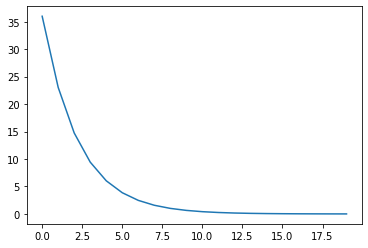

In [17]:
import matplotlib.pyplot as plt

# 学習が進んでいる様子が確認できます
plt.plot(loss_hist); plt.show()

前章ではnumpyでモデルを定義しましたが、今回のように深層学習ライブラリを使ってモデルを定義することで簡単に自動微分でき学習を行うことができます。

前章で扱ったモデルの定義と今回扱ったtrain関数とで、  
深層学習を使う上で必要な基本的なコーディングがほぼ全てできるようになりました。

ここまでしっかり理解すれば、深層学習一応わかります！と言っていいと思います。(ただしTPOによる)

# 演習 (余力がある人向け)

- 白紙の状態から下の図が書けて誤差の各パラメータでの微分が求められるように練習すると、かなり理解が深まると思います。(激しく推奨)
- より深く基礎から深層学習を理解したい人は、リンク先のchainerのチュートリアルも非常に参考になると思います。

<img src="https://tutorials.chainer.org/ja/_images/13_backpropagation.gif" width="760">

出典: https://tutorials.chainer.org/ja/13_Basics_of_Neural_Networks.html
